In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

In [80]:
df = pd.read_csv('train_processed.csv')

In [81]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,is_male,Embarked_Q,Embarked_S
0,0,3,22,1,0,7,1,0,1
1,1,1,38,1,0,71,0,0,0
2,1,3,26,0,0,7,0,0,1
3,1,1,35,1,0,53,0,0,1
4,0,3,35,0,0,8,1,0,1


In [82]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

RANDOM SEARCH CV

In [107]:
from sklearn.model_selection import RandomizedSearchCV
dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': [None, 'sqrt', 'log2']
}
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  
}
svc_params = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}
log_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga'],  
    'l1_ratio': [0, 0.3, 0.5, 0.7, 1] 
}
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [105]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [108]:
dt = DecisionTreeClassifier(random_state=42)
dt_search = RandomizedSearchCV(dt, dt_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
dt_search.fit(X_train_scaled, y_train)
print("Best Decision Tree params:", dt_search.best_params_)

knn = KNeighborsClassifier()
knn_search = RandomizedSearchCV(knn, knn_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
knn_search.fit(X_train_scaled, y_train)
print("Best KNN params:", knn_search.best_params_)

svm = SVC(random_state=42)
svm_search = RandomizedSearchCV(svm, svc_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
svm_search.fit(X_train_scaled, y_train)
print("Best SVC params:", svm_search.best_params_)

lr = LogisticRegression(random_state=42, max_iter=1000)
lr_search = RandomizedSearchCV(lr, log_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
lr_search.fit(X_train_scaled, y_train)
print("Best Logistic Regression params:", lr_search.best_params_)

rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=5, scoring='accuracy', random_state=42)
rf_search.fit(X_train_scaled, y_train)
print("Best Random Forest Regression params:", rf_search.best_params_)

Best Decision Tree params: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 3, 'criterion': 'log_loss'}
Best KNN params: {'weights': 'uniform', 'p': 2, 'n_neighbors': 11, 'metric': 'euclidean'}
Best SVC params: {'kernel': 'rbf', 'gamma': 'auto', 'C': 10}
Best Logistic Regression params: {'solver': 'liblinear', 'penalty': 'l1', 'l1_ratio': 0.7, 'C': 1}
Best Random Forest Regression params: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None}


STACKING CLASSIFIER

    ('svm',SVC(C=10)),
    ('lr',LogisticRegression(penalty='l1',solver='liblinear',l1_ratio=0.7,C=1,max_iter=1000)),
    ('knn',KNeighborsClassifier(weights='uniform',p=2,n_neighbors=11,metric='euclidean')),
    ('rf',RandomForestClassifier(n_estimators=400,min_samples_split=10,min_samples_leaf=4)),


In [147]:
base_learner = [
    ('nb',GaussianNB()),
    ('rf',RandomForestClassifier(n_estimators=400,min_samples_split=10,min_samples_leaf=4)),
    ('svm',SVC(C=10)),

]
meta_learner =LogisticRegression(penalty='l1',solver='liblinear',l1_ratio=0.7,C=1,max_iter=1000)


In [148]:
Stackingclf = StackingClassifier(estimators=base_learner, final_estimator=meta_learner,cv=5)
Stackingclf.fit(X_train_scaled,y_train)

StackingClassifier(cv=5,
                   estimators=[('nb', GaussianNB()),
                               ('rf',
                                RandomForestClassifier(min_samples_leaf=4,
                                                       min_samples_split=10,
                                                       n_estimators=400)),
                               ('svm', SVC(C=10))],
                   final_estimator=LogisticRegression(C=1, l1_ratio=0.7,
                                                      max_iter=1000,
                                                      penalty='l1',
                                                      solver='liblinear'))

In [149]:
pred = Stackingclf.predict(X_test_scaled)

In [150]:
from sklearn.metrics import accuracy_score

In [151]:
accuracy = accuracy_score(y_test,pred)
accuracy

0.8212290502793296

--- Predictions from each base model ---
   nb  rf  svm
0   0   0    0
1   0   0    0
2   0   0    0
3   1   1    1
4   1   1    1

--- Model Correlation Matrix ---
           nb        rf      svm
nb   1.000000  0.812172  0.80962
rf   0.812172  1.000000  0.90082
svm  0.809620  0.900820  1.00000


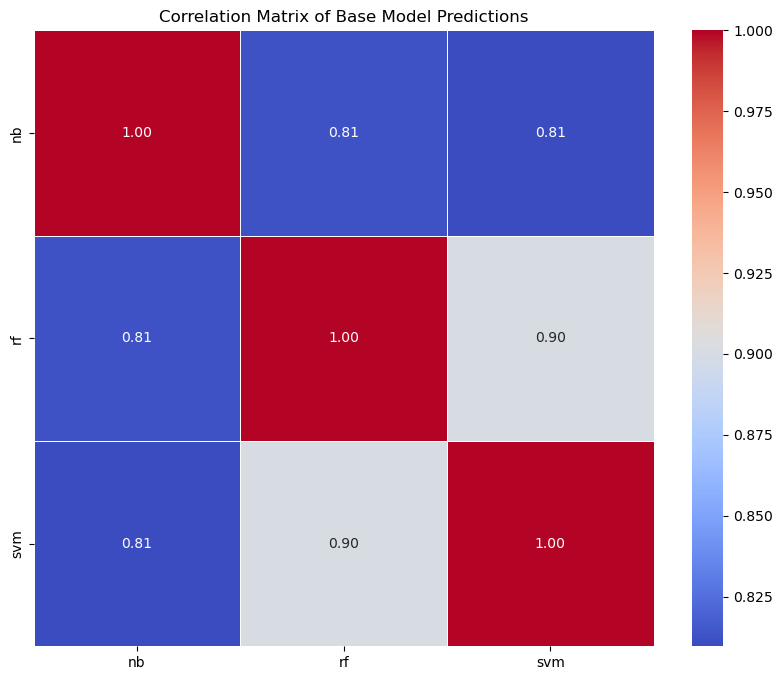

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


fitted_base_learners = {name: model for name, model in zip(Stackingclf.named_estimators_, Stackingclf.estimators_)}
predictions_df = pd.DataFrame()

for name, model in fitted_base_learners.items():
    predictions_df[name] = model.predict(X_test_scaled)

print("--- Predictions from each base model ---")
print(predictions_df.head())



correlation_matrix = predictions_df.corr()

print("\n--- Model Correlation Matrix ---")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Base Model Predictions')
plt.show()